In [1]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.generator import generate_balanced_dataset, draw_circles, draw_rectangles
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F


from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Processing and Visualization

In [2]:
data, metadata = generate_balanced_dataset(100)

In [3]:
data = pd.DataFrame(data)

In [4]:
metadata = pd.DataFrame(metadata)

In [5]:
metadata

,circle_center_x,circle_center_y,circle_radius,rect_tl_x,rect_tl_y,rect_br_x,rect_br_y
0,17,106,17,23,33,43,77
1,77,20,18,2,39,51,68
2,33,28,12,85,9,109,45
3,91,89,19,5,84,45,103
4,99,62,19,24,36,50,76
...,...,...,...,...,...,...,...
295,85,74,10,68,59,113,107
296,88,43,12,61,12,104,60
297,53,48,11,22,26,72,71
298,98,31,11,75,12,116,45


In [6]:
image_paths = [item for item in data[0]]
images = []

for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")

In [7]:
class EvalDataset(Dataset):
    def __init__(self, images, metadata):
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        self.metadata = torch.tensor(metadata).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        metadata = self.metadata[idx]
        return image, metadata
    
batch_size = 25

rectangle_metadata = metadata[["rect_tl_x",	"rect_tl_y"	,"rect_br_x"	,"rect_br_y"]]

train_images, test_images, train_rect_labels, test_rect_labels = train_test_split(images, rectangle_metadata.values, test_size=0.2, random_state=42)


# Create the training and test datasets for rectangles
train_rect_dataset = EvalDataset(train_images, train_rect_labels)
test_rect_dataset = EvalDataset(test_images, test_rect_labels)

# Create the dataloaders
batch_size = 64

# Rectangle dataloaders
train_rect_dataloader = DataLoader(train_rect_dataset, batch_size=batch_size, shuffle=True)
test_rect_dataloader = DataLoader(test_rect_dataset, batch_size=batch_size, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_88760/3642365311.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])


# Models and Evaluation Functions

In [8]:
class RectangleDetector(torch.nn.Module):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        t_x, t_y,b_x, b_y = (x[:, 0]), (x[:, 1]), (x[:, 2]), (x[:, 3])
        return t_x, t_y, b_x, b_y

In [9]:
def train_rect(model, dataloader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            tl_x, tl_y, br_x, br_y = model(inputs)
            outputs = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

def evaluate_model_rect(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            tl_x, tl_y, br_x, br_y = model(inputs)
            preds = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error: {mae:.4f}')
    return mae

# Rectangle

In [10]:
# rect = RectangleDetector()
# evaluate_model_rect(rect, train_rect_dataloader, device='cpu')
# print()
# train_rect(rect, train_rect_dataloader, nn.MSELoss(), torch.optim.Adam(rect.parameters(), lr=0.1), num_epochs=20, device='cpu')
# print()
# evaluate_model_rect(rect, test_rect_dataloader, device='cpu')

In [11]:
test_data, test_metadata = next(iter(test_rect_dataloader))
# rect.eval()
# instance = test_data[2].unsqueeze(0)
# t_x, t_y, b_x, b_y = rect(instance)
# plt.imshow(draw_rectangles(*test_metadata[2], t_x, t_y, b_x, b_y))

# Rectangle With SKI 

In [12]:
class EvalDataset(Dataset):
    def __init__(self, images, metadata):
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        
        # Unpack the metadata into separate variables
        metadata_tensor = torch.tensor(metadata).float()
        self.t_x, self.t_y, self.b_x, self.b_y = metadata_tensor[:, 0], metadata_tensor[:, 1], metadata_tensor[:, 2], metadata_tensor[:, 3]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        t_x, t_y, b_x, b_y = self.t_x[idx], self.t_y[idx], self.b_x[idx], self.b_y[idx]
        return image, t_x, t_y, b_x, b_y

batch_size = 64

rectangle_metadata = metadata[["rect_tl_x", "rect_tl_y", "rect_br_x", "rect_br_y"]]
train_images, test_images, train_rect_labels, test_rect_labels = train_test_split(images, rectangle_metadata.values, test_size=0.2, random_state=42)

# Create the training and test datasets for rectangles
train_rect_dataset = EvalDataset(train_images, train_rect_labels)
test_rect_dataset = EvalDataset(test_images, test_rect_labels)

train_rect_dataloader = DataLoader(train_rect_dataset, batch_size=batch_size, shuffle=True)
test_rect_dataloader = DataLoader(test_rect_dataset, batch_size=batch_size, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_88760/1125484005.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])


In [13]:
def evaluate_model_rect(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, t_x, t_y, b_x, b_y in dataloader:
            inputs = inputs.to(device)
            t_x, t_y, b_x, b_y = t_x.to(device), t_y.to(device), b_x.to(device), b_y.to(device)
            tl_x, tl_y, br_x, br_y = model(inputs)
            preds = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)
            labels = torch.stack((t_x, t_y, b_x, b_y), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error: {mae:.4f}')
    return mae

In [14]:
rect = RectangleDetector()

expression_1 = "all i. (Rect(i, t1, t2, b1, b2))"
expression_2 = "all t1 . ( (t1 = t11) and (b1 = b11) and (t2 = t22) and (b2 = b22) )"
expression_3 = "all i. ((t1 < b1) and (t2 < b2))"

learning_rules = [expression_1, expression_2, expression_3]

loader = LoaderWrapper(loader=train_rect_dataloader, variables=["i"], targets=["t11", "t22", "b11", "b22"])

rule_to_data_loader_mapping = {
    expression_1: [loader],
    expression_2: [loader], 
    expression_3: None,
}

predicates = {
    "Rect": rect
}

quantifier_impls = { "forall" : "min" }

connective_impls = {"eq": "sqrt"}

kb = KnowledgeBase(learning_rules = learning_rules, ancillary_rules=[], rule_to_data_loader_mapping=rule_to_data_loader_mapping, 
                   predicates=predicates, quantifier_impls=quantifier_impls,connective_impls=connective_impls)

In [19]:
evaluate_model_rect(rect, train_rect_dataloader, device='cpu')
print()
kb.optimize(num_epochs=31, lr=0.0001, log_steps=6)
print()
evaluate_model_rect(rect, test_rect_dataloader, device='cpu')

Mean Absolute Error: 17.5011



In [16]:
kb.declarations

{'t1': tensor([45.3496, 38.5537, 47.9868, 45.1189, 42.5921, 53.1927, 51.9242, 50.3865,
         50.7118, 41.2293, 59.0814, 39.1836, 36.9356, 48.8767, 40.3396, 39.1328,
         41.3652, 60.3423, 51.1646, 66.4599, 45.0757, 42.1057, 47.2135, 57.9888,
         48.5130, 45.4457, 57.4286, 50.7582, 49.6212, 42.4927, 45.7355, 41.4857,
         44.7381, 51.7885, 56.0529, 38.2494, 43.0487, 43.4770, 41.2944, 36.4571,
         43.0929, 54.8428, 39.7077, 38.3729, 55.9028, 45.3338, 39.6644, 56.0408,
         50.7841, 50.0780, 45.5672, 36.7507, 53.5420, 50.8782, 45.6287, 46.1566,
         60.7166, 42.6038, 48.0520, 45.0982, 52.5086, 54.9555, 54.4461, 49.7482],
        grad_fn=<SelectBackward0>),
 't2': tensor([34.4975, 34.4865, 38.4205, 59.3384, 41.7820, 37.1621, 69.1624, 42.7128,
         50.8445, 57.0207, 45.9916, 38.8479, 65.4731, 60.7862, 56.0873, 50.2768,
         49.9392, 61.8269, 41.3678, 40.6835, 35.5140, 38.9733, 59.8036, 34.7687,
         63.3776, 56.3560, 44.3337, 61.9629, 33.0869, 52.593

In [18]:
rect.eval()
instance = test_data[2].unsqueeze(0)
t_x, t_y, b_x, b_y = rect(instance)
plt.imshow(draw_rectangles(*test_data[2], predicted_top_left_x=t_x, predicted_top_left_y=t_y, predicted_bottom_right_x=b_x, predicted_bottom_right_y=b_y))

TypeError: draw_rectangles() missing 1 required positional argument: 'bottom_right_y'

{'i': tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.

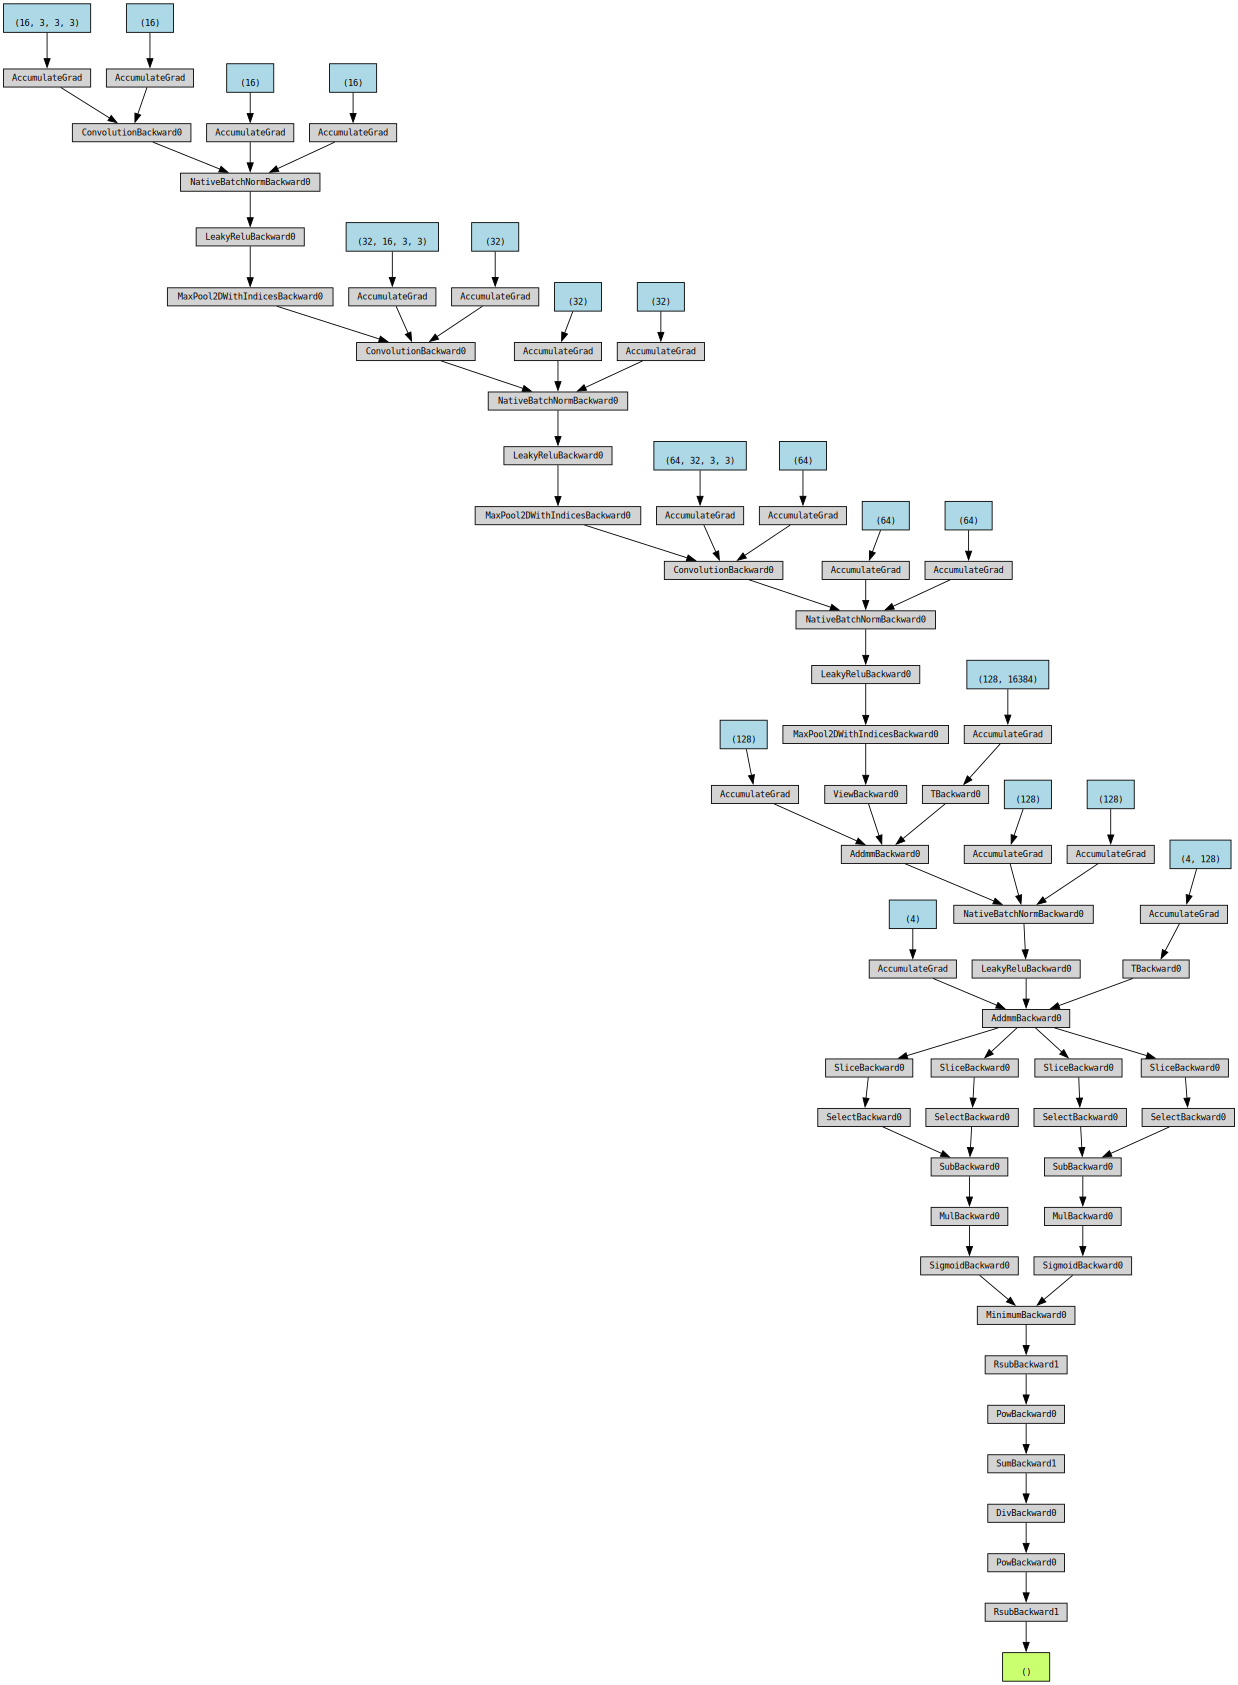

In [ ]:
batch = next(iter(train_rect_dataloader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loader)

print(var_mapping)

kb.rules[2].comp_graph(var_mapping)

In [ ]:
var_mapping["t11"].shape

torch.Size([64])